In [21]:
# dataset = cifar10
# model = mobilenet
# optimizer = ADAM (0.001)
# loss = categorical_crossentropy
# batch_size = 32
# decay = l2 (0.01)
# augmentation = off
# validation_split = 0.2

In [22]:
import tensorflow as tf
import os
import numpy as np

from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Input, Flatten, AveragePooling2D, Add
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
# https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import L2

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import fashion_mnist

In [23]:
batch_size=32
epochs=100
num_classes=10 
depth=20 

In [24]:
model_type = 'MobileNet%d' % (depth)

In [25]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train/255
x_test = x_test/255

print(x_train.shape)
print(x_test.shape)

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
input_shape=x_train.shape[1:]

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [26]:
#datagen = ImageDataGenerator(rotation_range=40, horizontal_flip=True, zoom_range=0.1, width_shift_range=0.05, height_shift_range=0.05)
#augmented_data = datagen.flow(x_train[:40000], y_train[:40000])

In [27]:
def mobilenet(input_size=(32, 32), l2_decay=0.1, N_CLASSES=10):
    """
    Builds the MobileNet model.
    :param tuple input_size: The height and width (in that order) of the
        model input.
    :param float l2_decay: The amount of L2 weight decay to add to the
        loss. Applies only to kernels, not biases.
    :return tensorflow.keras.Sequential: A MobileNet model.
    """

    model = Sequential()

    def _add_bn_relu():
        model.add(BatchNormalization(scale=False))
        model.add(ReLU())

    def _add_depthwise_block(strides=1):
        model.add(DepthwiseConv2D(
            (3, 3),
            strides=strides,
            padding='same',
            kernel_regularizer=L2(l2=l2_decay)))
        _add_bn_relu()

    def _add_pointwise_block(filters):
        model.add(Conv2D(filters, (1, 1), kernel_regularizer=L2(l2=l2_decay)))
        _add_bn_relu()

    model.add(Conv2D(
        32, (3, 3),
        strides=2,
        padding='same',
        kernel_regularizer=L2(l2=l2_decay),
        input_shape=input_size + (3,))) # change the channel dimension here
    _add_bn_relu()
    _add_depthwise_block()
    _add_pointwise_block(64)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(128)
    _add_depthwise_block()
    _add_pointwise_block(128)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(256)
    _add_depthwise_block()
    _add_pointwise_block(256)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(512)
    for _ in range(5):
        _add_depthwise_block()
        _add_pointwise_block(512)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(1024)
    _add_depthwise_block()
    _add_pointwise_block(1024)

    model.add(AveragePooling2D(pool_size=(input_size[0] // 32, input_size[1] // 32)))

    model.add(Flatten())
    model.add(Dense(N_CLASSES, kernel_regularizer=L2(l2=l2_decay)))
    model.add(Softmax())

    return model


model = mobilenet(input_size=(32, 32), l2_decay=0.001, N_CLASSES=10)
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization_54 (Batc (None, 16, 16, 32)        96        
_________________________________________________________________
re_lu_54 (ReLU)              (None, 16, 16, 32)        0         
_________________________________________________________________
depthwise_conv2d_26 (Depthwi (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_55 (Batc (None, 16, 16, 32)        96        
_________________________________________________________________
re_lu_55 (ReLU)              (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 64)       

In [28]:
#model_tf = tf.keras.applications.mobilenet.MobileNet(input_shape=(32, 32, 3), weights=None, classes=10)
#print(model_tf.summary())

In [29]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [30]:
#steps = int(x_train.shape[0]/batch_size) 

history = model.fit(x_train, y_train, epochs=epochs, verbose=2, validation_split=0.1)

Epoch 1/100
1407/1407 - 25s - loss: 5.3225 - accuracy: 0.3002 - val_loss: 3.5725 - val_accuracy: 0.3964
Epoch 2/100
1407/1407 - 17s - loss: 2.9150 - accuracy: 0.4089 - val_loss: 2.4996 - val_accuracy: 0.4020
Epoch 3/100
1407/1407 - 16s - loss: 2.2153 - accuracy: 0.4517 - val_loss: 1.9774 - val_accuracy: 0.4902
Epoch 4/100
1407/1407 - 17s - loss: 1.9822 - accuracy: 0.4956 - val_loss: 2.0054 - val_accuracy: 0.4874
Epoch 5/100
1407/1407 - 16s - loss: 1.8122 - accuracy: 0.5350 - val_loss: 1.6633 - val_accuracy: 0.5778
Epoch 6/100
1407/1407 - 16s - loss: 1.6040 - accuracy: 0.5955 - val_loss: 1.6404 - val_accuracy: 0.5690
Epoch 7/100
1407/1407 - 15s - loss: 1.4676 - accuracy: 0.6348 - val_loss: 1.7439 - val_accuracy: 0.5498
Epoch 8/100
1407/1407 - 17s - loss: 1.3782 - accuracy: 0.6634 - val_loss: 1.3300 - val_accuracy: 0.6820
Epoch 9/100
1407/1407 - 16s - loss: 1.3061 - accuracy: 0.6852 - val_loss: 1.5271 - val_accuracy: 0.6218
Epoch 10/100
1407/1407 - 15s - loss: 1.2379 - accuracy: 0.7045 -

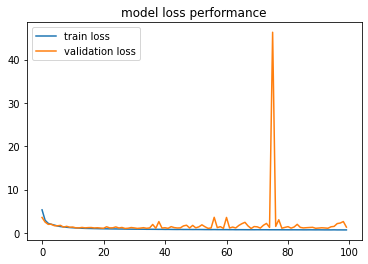

In [31]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss performance')
plt.legend(['train loss', 'validation loss'])
plt.show()

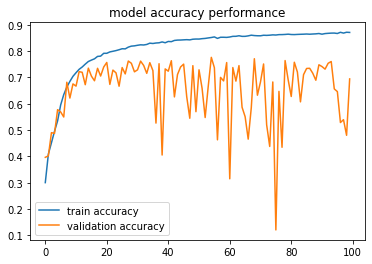

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy performance')
plt.legend(['train accuracy', 'validation accuracy'])
plt.show()

In [33]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 1.3443 - accuracy: 0.6919


[1.3443496227264404, 0.6919000148773193]